In [24]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multinetx as mx
import scipy.io as sio
from networkx.readwrite import json_graph
import json
import pandas as pd
import os
import sys
from jinja2 import Environment, FileSystemLoader, Template

print("Done importing packages :)")

Done importing packages :)


In [40]:
## Define useful functions

def write_mx_to_json(filename, mg, nNodes, pos, nLayers, nodes_to_remove = []):
    
    # filename the complete name of the output file (data/slide_x.json)
    # mx the multilayer network as a multinetx object
    # nNodes the number of nodes in the first layer
    # pos a dictionary of node coordinates
    # nLayers the number of layers in the second aspect.
    # nodes_to_remove is a list of nodes that should not exist in each layer. Default = []
    
    # From the sparse adj, make a networkx graph and add node attributes
    G1 = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

    # Remove nodes from G
    G1.remove_nodes_from(nodes_to_remove)

    # Recreate the graph G to make the rest work nicely.
    G = nx.from_numpy_array(nx.adjacency_matrix(G1).todense())


    # Create dictionaries pretending like all nodes exist
    scalefact = 20
    L2_classes = np.arange(nLayers)
    L2_array_original = np.array([])
    z_shift = 2
    z_array_original = np.array([])
    x_orig = np.array([])
    y_orig = np.array([])
    L1_orig = np.array([])
    for level in L2_classes:
        L2_array_original = np.concatenate((L2_array_original, np.array([float(level) for i in np.arange(nNodes)])))
        z_array_original = np.concatenate((z_array_original, np.array([float(level*z_shift) for i in np.arange(nNodes)])))
        x_orig = np.concatenate((x_orig, [pos[key][0]+scalefact for key in pos]))
        y_orig = np.concatenate((y_orig, [pos[key][1]+scalefact for key in pos]))
        L1_orig = np.concatenate((L1_orig, [i for i in np.arange(nNodes)]))

    # Need to delete nodes from our attribute dictionaries, too
    L2_array = np.delete(L2_array_original, nodes_to_remove, 0)
    z_array = np.delete(z_array_original, nodes_to_remove, 0)
    x_array = np.delete(x_orig, nodes_to_remove, 0)
    y_array = np.delete(y_orig, nodes_to_remove, 0)
    L1_array = np.delete(L1_orig, nodes_to_remove, 0)

    ## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

    id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
    x_dict = {}
    y_dict = {}
    L2_dict = {i:l2 for i,l2 in enumerate(L2_array)}
    z_dict = {i:z_val for i,z_val in enumerate(z_array)}
    x_dict = {i:x_val for i,x_val in enumerate(x_array)}
    y_dict = {i:y_val for i,y_val in enumerate(y_array)}
    L1_dict = {i:L1_val for i,L1_val in enumerate(L1_array)}


    nx.set_node_attributes(G, id_dict, name = "name")
    nx.set_node_attributes(G, x_dict, name = "x")
    nx.set_node_attributes(G, y_dict, name = "y")
    nx.set_node_attributes(G, z_dict, name = "z")
    nx.set_node_attributes(G, L1_dict, name= "L1")
    nx.set_node_attributes(G, L2_dict, name= "L2")


    G_json = json_graph.node_link_data(G)
    
    # Write for visualization function
    G_json_viz = json.dumps(G_json, indent = 4)  
    
    # To save as a .json file
    with open(filename, 'w') as fp:
        json.dump(G_json, fp)

    print(f"done writing mx to {filename}")
    
    return G_json_viz





#Finished defining functions
print("finished defining functions")


def visualize(
        mxgraph,
        theme="dark",
        path_html="visualization_output.html",
        title="MX viz",
        save_file=True,
    ):
    

    # Find the module absolute path and locate templates
#     module_root = os.path.join(os.path.dirname('./'), "templates")
    module_root = "./"
    env = Environment(loader=FileSystemLoader(module_root))

    
    # Read in the D3 save pages code and include in the exported html
    d3_save_svg_path = "./d3-save-svg-gh-pages/assets/d3-save-svg.min.js"
    with open(d3_save_svg_path,'r') as f:
        d3_save_svg = f.readlines()

  
    if theme=="dark":
        
        js_path = './javascript/mx_viz.js'
        with open(js_path, "r") as f:
            js_text = f.read()
        
        css_path = './style/style.css'
        with open(css_path, "r") as f:
            css_text = f.read()
            
        # Jinja
        template = env.get_template("./templates/mx_viz.html").render(
            title=title,
            js_text=js_text,
            css_text=css_text,
            mxgraph=mxgraph,
            d3_save_svg=d3_save_svg[0]
        )
        
    elif theme == "light":
        
        js_path = './javascript/mx_vizlighttheme.js'
        with open(js_path, "r") as f:
            js_text = f.read()
        
        css_path = './style/style_lighttheme.css'
        with open(css_path, "r") as f:
            css_text = f.read()
            
        # Jinja
        template = env.get_template("./templates/mx_viz_lighttheme.html").render(
            title=title,
            js_text=js_text,
            css_text=css_text,
            mxgraph=mxgraph,
            d3_save_svg=d3_save_svg[0]
        )
        

            

    if save_file:
        with open(path_html, "wb") as outfile:
            print("Wrote visualization to: %s" % (path_html))
            outfile.write(template.encode("utf-8"))

    return template

def visualize_timeseries(
        mxgraph,
        path_html="visualization_timeseries_output.html",
        title="MX viz",
        save_file=True,
    ):
    

    # Find the module absolute path and locate templates
#     module_root = os.path.join(os.path.dirname('./'), "templates")
    module_root = "./"
    env = Environment(loader=FileSystemLoader(module_root))
    
    # Read in the D3 save pages code and include in the exported html
    d3_save_svg_path = "./d3-save-svg-gh-pages/assets/d3-save-svg.min.js"
    with open(d3_save_svg_path,'r') as f:
        d3_save_svg = f.readlines()


    # Find the absolute module path and the static files
#         js_path = os.path.join(os.path.dirname(__file__), "static", "kmapper.js")
    js_path = './javascript/mx_viz_timeseries.js'
    print(js_path)
    with open(js_path, "r") as f:
        js_text = f.read()


    css_path = './style/style_timeseries.css'
    with open(css_path, "r") as f:
        css_text = f.read()

    # Jinja
    template = env.get_template("./templates/mx_viz_timeseries.html").render(
        title=title,
        js_text=js_text,
        css_text=css_text,
        mxgraph=mxgraph,
        d3_save_svg=d3_save_svg[0]
    )



    if save_file:
        with open(path_html, "wb") as outfile:
            print("Wrote visualization to: %s" % (path_html))
            outfile.write(template.encode("utf-8"))

    return template



finished defining functions


## Multilayer network ex 1: Two aspects, two layers

Aspect L1: nodes as usual
Aspect L2: "A" or "B"

In [41]:
# Set filename
filename = "data/mx_2layers2.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 2

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=216)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=130)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph with mx
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


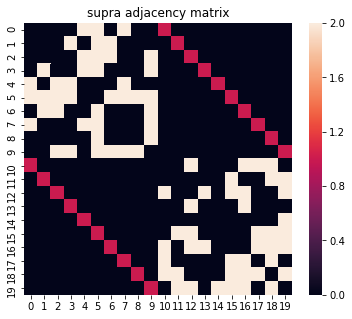

In [42]:
## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [43]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)

# Feel free to change the layout used here. It will be reflected in the d3 plot. However pos is changed, it should
# remain a dictionary mapping nodes to coordinate arrays with at least an x and y position.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=2)

G2 = write_mx_to_json(filename,mg, nNodes, pos, nLayers)
visualize(G2,theme="dark",path_html="visualization_output_example.html")


done writing mx to data/mx_2layers2.json
Wrote visualization to: visualization_output_example.html


'<!DOCTYPE html>\n<meta charset="utf-8">\n\n<head>\n    <title>MX viz | KeplerMapper</title>\n    <style>    #header {\n      margin: auto;\n      margin-top: 30px;\n      width: 95%;\n      height: 40px;\n      padding: 10px;\n      overflow: auto;\n      background: rgba(255,255,255,0.06);\n    \n    }\n    \n    h2 {\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      margin-top: 5px;\n      margin-bottom: 30px;\n      font-weight: lighter;\n    }\n    \n    #header h1 {\n      margin: auto;\n      opacity: 1;\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      font-weight: 300;\n      padding-left: 20px;\n    \n    }\n    \n    #svgdiv-mx {\n      margin: auto;\n      padding: 0px 30px;\n    }\n    \n    #svg-mx {\n      margin: 0 auto;\n      isolation: isolate;\n    }\n    \n    #svg-sadj {\n      margin: 0 auto;\n    }\n    \n    #footer {\n      position: fixed;\n      left: 0;\n      bottom: 0;\n      ma

## Ex 2: 2 aspects, 5 layers


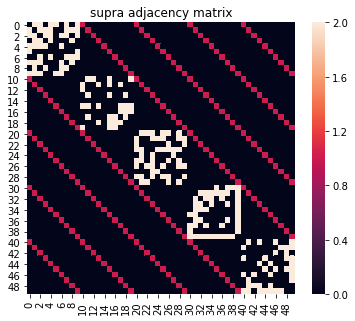

In [44]:
# Set filename
filename = "data/mx_5layers.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 5

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3,g4,g5],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [45]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
# write_mx_to_json(filename, mx, nNodes, pos, nLayers)
G2 = write_mx_to_json(filename,mg, nNodes, pos, nLayers)
visualize(G2)


done writing mx to data/mx_5layers.json
Wrote visualization to: visualization_output.html


'<!DOCTYPE html>\n<meta charset="utf-8">\n\n<head>\n    <title>MX viz | KeplerMapper</title>\n    <style>    #header {\n      margin: auto;\n      margin-top: 30px;\n      width: 95%;\n      height: 40px;\n      padding: 10px;\n      overflow: auto;\n      background: rgba(255,255,255,0.06);\n    \n    }\n    \n    h2 {\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      margin-top: 5px;\n      margin-bottom: 30px;\n      font-weight: lighter;\n    }\n    \n    #header h1 {\n      margin: auto;\n      opacity: 1;\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      font-weight: 300;\n      padding-left: 20px;\n    \n    }\n    \n    #svgdiv-mx {\n      margin: auto;\n      padding: 0px 30px;\n    }\n    \n    #svg-mx {\n      margin: 0 auto;\n      isolation: isolate;\n    }\n    \n    #svg-sadj {\n      margin: 0 auto;\n    }\n    \n    #footer {\n      position: fixed;\n      left: 0;\n      bottom: 0;\n      ma

## Time series example

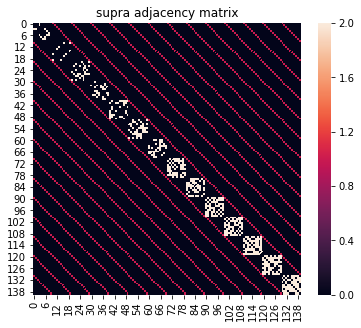

In [46]:
# Set filename
filename = "data/mx_timeseries.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 14

# Use multinetx to generate fourteen graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,((i+3)/(nLayers+5)),seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

In [32]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
# write_mx_to_json(filename, mx, nNodes, pos, nLayers)


G2 = write_mx_to_json(filename,mg, nNodes, pos, nLayers)
visualize_timeseries(G2, path_html="visualization_output_timeseries_example.html")

done writing mx to data/mx_timeseries.json
./javascript/mx_viz_timeseries.js
Wrote visualization to: visualization_output_timeseries_example.html


'<!DOCTYPE html>\n<meta charset="utf-8">\n\n<head>\n  <title>MX viz</title>\n  <style>#header {\n    margin: auto;\n    margin-top: 30px;\n    margin-bottom: 20px;\n    width: 95%;\n    height: 40px;\n    padding: 10px;\n    overflow: auto;\n    background: rgba(255,255,255,0.06);\n  \n    }\n  \n    #header h1 {\n      margin: auto;\n      opacity: 1;\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      font-weight: 300;\n      padding-left: 20px;\n  \n    }\n  \n    h2 {\n      color: white;\n      font-family: "Helvetica Neue", Helvetica, sans-serif;\n      margin-top: 5px;\n      margin-bottom: 30px;\n      font-weight: lighter;\n    }\n  \n    #svgdiv-mx {\n      /* float: left; */\n      margin: 10px 20px 10px 20px;\n      color: white;\n      isolation: isolate;\n  \n    }\n  \n    #svg-mx {\n      align-items: center;\n      margin: auto;\n      position: relative;\n      display: block;\n    }\n  \n    #options-div {\n      margin: auto;\n  

In [33]:
mx

<module 'multinetx' from '/opt/conda/lib/python3.7/site-packages/multinetx/__init__.py'>

## Non-identity inter-layer connections

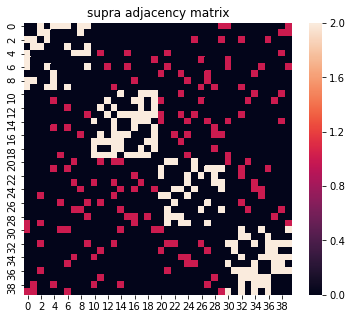

In [34]:
# Set filename
filename = "data/mx_nonidentity.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 4

# Use multinetx to generate graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Now we randomly connect nodes in separate layers.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [35]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
write_mx_to_json(filename, mg, nNodes, pos, nLayers)

TypeError: 'module' object is not iterable

## Case where nodes are not in every layer

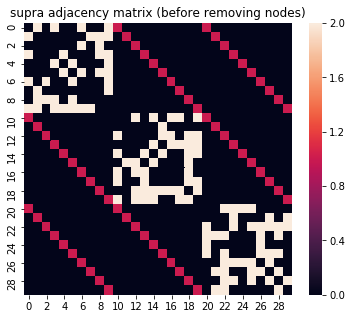

In [36]:
# When we do not have all nNodes in each layer, we will proceed as before but then delete nodes towards the end

# Set filename
filename = "data/mx_missingnodes.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 3

# Set which nodes should not exist in the final graph
nodes_to_remove = [11, 17, 21, 25, 28]

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=54)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=194)


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix (before removing nodes)');



In [39]:
# Since nodes don't exist in every layer, it might be easier to visualize with a circular layout...
pos = nx.circular_layout(g1)

# Write to json -- make sure to add nodes_to_remove
write_mx_to_json(filename, mg, nNodes, pos, nLayers, nodes_to_remove)

done writing mx to data/mx_motifs.json


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


'{\n    "directed": false,\n    "multigraph": false,\n    "graph": {},\n    "nodes": [\n        {\n            "name": "id0",\n            "x": 21.0,\n            "y": 20.00000000851495,\n            "z": 0.0,\n            "L1": 0.0,\n            "L2": 0.0,\n            "id": 0\n        },\n        {\n            "name": "id1",\n            "x": 20.62348980673322,\n            "y": 20.781831491457613,\n            "z": 0.0,\n            "L1": 1.0,\n            "L2": 0.0,\n            "id": 1\n        },\n        {\n            "name": "id2",\n            "x": 19.77747908377275,\n            "y": 20.974927885832244,\n            "z": 0.0,\n            "L1": 2.0,\n            "L2": 0.0,\n            "id": 2\n        },\n        {\n            "name": "id3",\n            "x": 19.09903119890099,\n            "y": 20.43388381343525,\n            "z": 0.0,\n            "L1": 3.0,\n            "L2": 0.0,\n            "id": 3\n        },\n        {\n            "name": "id4",\n            "x":

## Motifs example

In [38]:
# Set filename
filename = "data/mx_motifs.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 7

# Define number of levels
nLayers = 2

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph with mx
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


In [ ]:
## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

In [ ]:
# Write to json file

# See previous cells for descriptions
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=1)

write_mx_to_json(filename,mx, nNodes, pos, nLayers)

## Centrality example

In [ ]:
# Set filename
filename = "data/mx_centrality.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 5

# Define number of levels
nLayers = 3

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=13)
g2 = mx.generators.barabasi_albert_graph(nNodes,1,seed=48)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=72)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [ ]:
# Write to json file

# See previous cells for details.
pos = nx.circular_layout(g1)

# write to json file
write_mx_to_json(filename, mx, nNodes, pos, nLayers)

## Communities example

In [ ]:
# Set filename
filename = "data/mx_communities.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 20

# Define number of levels
nLayers = 3

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.powerlaw_cluster_graph(nNodes,2,0.7,seed=48)
g2 = mx.generators.powerlaw_cluster_graph(nNodes,2,0.9,seed=68)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.1,seed=72)


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [ ]:
# Write to json file

# See previous cells for details.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=1)

# write to json file
write_mx_to_json(filename, mx, nNodes, pos, nLayers)